## Setup

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
from astropy.coordinates import SkyCoord

from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis, WcsNDMap
from gammapy.modeling.models import SkyModel, SkyPointSource, Absorption, AbsorbedSpectralModel
from gammapy.astro.darkmatter import DMAnnihilation, SigmaVEstimator
from gammapy.cube.simulate import simulate_dataset
from gammapy.modeling import Fit

## Load IRFs

In [2]:
filename = "$CTADATA/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
irfs = load_cta_irfs(filename)

## Define map geometry

In [3]:
GLON = 96.34 * u.Unit("deg")
GLAT = -60.19 * u.Unit("deg")
src_pos = SkyCoord(GLON, GLAT, frame="galactic")
emin = 0.03 
emax = 100
unit = "TeV"
lg_emin = np.log10(emin)
lg_emax = np.log10(emax)
ENERGY_BINS = 31

In [4]:
axis = MapAxis.from_edges(
    np.logspace(lg_emin, lg_emax, ENERGY_BINS),
    unit=unit,
    name="energy",
    interp="log",
)
geom = WcsGeom.create(
    skydir=src_pos, binsz=0.02, width=(2, 2), coordsys="GAL", axes=[axis]
)

## Declare observation values

In [5]:
pointing = src_pos
livetime = 50 * u.hour
offset = 2 * u.deg

## Build model and create dataset

**Declare constants and parameters for our DM model**

In [6]:
JFAC = 3.41e19 * u.Unit("GeV2 cm-5") # <--- point source
mDM = 5000*u.Unit("GeV")
channel = "b"
redshift = 5

**Define 3D Sky Model**

In [7]:
flux_model = DMAnnihilation(
    mass=mDM, 
    channel=channel, 
    jfactor=JFAC, 
    z=redshift
)

absorption_model = Absorption.read_builtin('dominguez')
flux_model = AbsorbedSpectralModel(flux_model, absorption_model, redshift)

spatial_model = SkyPointSource(lat_0=GLAT, lon_0=GLON)
sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=flux_model
)

**Create simulated dataset**

In [8]:
simulated_ds = simulate_dataset(
    sky_model, 
    geom=geom, 
    pointing=pointing, 
    irfs=irfs, 
    livetime=livetime, 
    offset=offset
)

## Display our simulated dataset (optional)

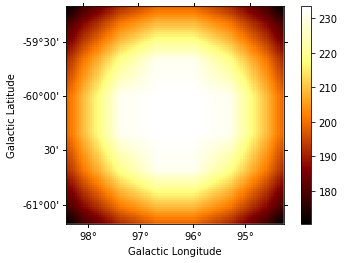

In [9]:
npred_map = simulated_ds.npred()
npred_map.sum_over_axes().plot(add_cbar=True);
#npred_map.plot_interactive(add_cbar=True);

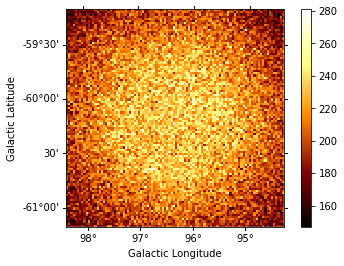

In [10]:
simulated_ds.counts.sum_over_axes().plot(add_cbar=True);
#simulated_ds.counts.plot_interactive(add_cbar=True);


## Estimate sigma v

**Enable inspection**

In [11]:
import logging
logging.basicConfig()
logging.getLogger("gammapy.astro.darkmatter.utils").setLevel("INFO")

**Instatiate estimator**

In [12]:
masses = [70, 200, 500, 5000, 10000, 50000, 100000]*u.GeV
channels = ["b", "t", "tau", "Z"] 
estimator = SigmaVEstimator(simulated_ds, masses, channels, jfact=JFAC)

**Run estimator and fetch results**

In [13]:
%%time
NumberOfRuns = 1
for run in range(NumberOfRuns):
    result = estimator.run()
    
## TODO HERE
## store results in a different data structure when fitting several runs

INFO:gammapy.astro.darkmatter.utils:Channel: b
INFO:gammapy.astro.darkmatter.utils:Mass: 70.0 GeV
INFO:gammapy.astro.darkmatter.utils:Sigma v: 2.988922184857816e-23 cm3 / s
INFO:gammapy.astro.darkmatter.utils:Mass: 200.0 GeV
INFO:gammapy.astro.darkmatter.utils:Sigma v: 5.95569066375514e-24 cm3 / s
INFO:gammapy.astro.darkmatter.utils:Mass: 500.0 GeV
INFO:gammapy.astro.darkmatter.utils:Sigma v: 3.533559508101714e-24 cm3 / s
INFO:gammapy.astro.darkmatter.utils:Mass: 5000.0 GeV
INFO:gammapy.astro.darkmatter.utils:Sigma v: 2.349941651958125e-24 cm3 / s
INFO:gammapy.astro.darkmatter.utils:Mass: 10000.0 GeV
INFO:gammapy.astro.darkmatter.utils:Sigma v: 2.7133289676921827e-24 cm3 / s
INFO:gammapy.astro.darkmatter.utils:Mass: 50000.0 GeV
INFO:gammapy.astro.darkmatter.utils:Sigma v: 6.0535526128887775e-24 cm3 / s
INFO:gammapy.astro.darkmatter.utils:Mass: 100000.0 GeV
INFO:gammapy.astro.darkmatter.utils:Sigma v: 9.372907118910008e-24 cm3 / s
INFO:gammapy.astro.darkmatter.utils:Channel: t
INFO:gamm

CPU times: user 4min 21s, sys: 10.4 s, total: 4min 31s
Wall time: 4min 45s


## Inspection of results

**Display results for channel tau**

In [14]:
result

{'b': <Table length=7>
   mass          sigma_v         ...      likemin      
   GeV           cm3 / s         ...                   
 float64         float64         ...      float64      
 -------- ---------------------- ... ------------------
     70.0  2.988922184857816e-23 ... -9223824.762661023
    200.0   5.95569066375514e-24 ... -9223823.406314475
    500.0  3.533559508101714e-24 ... -9223826.385245025
   5000.0  2.349941651958125e-24 ... -9223820.781015303
  10000.0 2.7133289676921827e-24 ... -9223820.430312801
  50000.0 6.0535526128887775e-24 ... -9223820.673859194
 100000.0  9.372907118910008e-24 ... -9223819.833385937, 't': <Table length=7>
   mass          sigma_v         ...      likemin      
   GeV           cm3 / s         ...                   
 float64          object         ...       object      
 -------- ---------------------- ... ------------------
     70.0                   None ...               None
    200.0 1.3106711702039845e-23 ... -9223821.109924318
  

In [15]:
result["b"]

mass,sigma_v,scale,scale_ul,likeprofile,likemin
GeV,cm3 / s,,,,
float64,float64,float64,float64,object,float64
70.0,2.988922184857816e-23,598.4464886214365,996.3073949526054,"{'values': array([-631.94346468, -581.72346658, -531.50346849, -481.28347039, -431.0634723 , -380.84347421, -330.62347611, -280.40347802, -230.18347993, -179.96348183, -129.74348374, -79.52348564, -29.30348755, 20.91651054, 71.13650864, 121.35650673, 171.57650482, 221.79650292, 272.01650101, 322.23649911, 372.4564972 , 422.67649529, 472.89649339, 523.11649148, 573.33648957, 623.55648767, 673.77648576, 723.99648386, 774.21648195, 824.43648004, 874.65647814, 924.87647623, 975.09647432, 1025.31647242, 1075.53647051, 1125.75646861, 1175.9764667 , 1226.19646479, 1276.41646289, 1326.63646098, 1376.85645907, 1427.07645717, 1477.29645526, 1527.51645336, 1577.73645145, 1627.95644954, 1678.17644764, 1728.39644573, 1778.61644382, 1828.83644192]), 'likelihood': array([-9223818.45180473, -9223818.45180473, -9223818.45180473, -9223818.45180473, -9223818.45180473, -9223818.45180473, -9223818.45180473, -9223818.45180473, -9223818.45180473, -9223818.45180473, -9223818.45180473, -9223818.45180473, -9223818.45180473, -9223818.88890446, -9223819.87329037, -9223820.766142 , -9223821.56789044, -9223822.2789606 , -9223822.89976898, -9223823.43072674, -9223823.87223801, -9223824.2246999 , -9223824.4885054 , -9223824.66403937, -9223824.75168157, -9223824.75180802, -9223824.66478675, -9223824.49098087, -9223824.23074963, -9223823.8844466 , -9223823.45242063, -9223822.93501552, -9223822.33257016, -9223821.64541933, -9223820.87389352, -9223820.01831891, -9223819.07901706, -9223818.05630553, -9223816.95049874, -9223815.76190639, -9223814.49083397, -9223813.13758436, -9223811.70245565, -9223810.18574419, -9223808.58773991, -9223806.90873329, -9223805.14900722, -9223803.30884458, -9223801.38852341, -9223799.38832037])}",-9223824.762661023
200.0,5.95569066375514e-24,113.82845260229817,198.5230221251713,"{'values': array([-150.58707419, -139.79460371, -129.00213323, -118.20966275, -107.41719227, -96.62472179, -85.83225131, -75.03978082, -64.24731034, -53.45483986, -42.66236938, -31.8698989 , -21.07742842, -10.28495794, 0.50751255, 11.29998303, 22.09245351, 32.88492399, 43.67739447, 54.46986495, 65.26233544, 76.05480592, 86.8472764 , 97.63974688, 108.43221736, 119.22468784, 130.01715832, 140.80962881, 151.60209929, 162.39456977, 173.18704025, 183.97951073, 194.77198121, 205.5644517 , 216.35692218, 227.14939266, 237.94186314, 248.73433362, 259.5268041 , 270.31927458, 281.11174507, 291.90421555, 302.69668603, 313.48915651, 324.28162699, 335.07409747, 345.86656796, 356.65903844, 367.45150892, 378.2439794 ]), 'likelihood': array([-9223818.46094269, -9223818.46094269, -9223818.46094269, -9223818.46094269, -9223818.46094269, -9223818.46094269, -9223818.46094269, -9223818.46094269, -9223818.46094269, -9223818.46094269, -9223818.46094269, -9223818.46094269, -9223818.46094269, -9223818.46094269, -9223818.50519138, -9223819.39869272, -9223820.20168814, -9223820.91441745, -9223821.53711918, -9223822.07002916, -9223822.51338039, -9223822.8674035 , -9223823.13232807, -9223823.30838063, -9223823.3957851 , -9223823.39476494, -9223823.30554007, -9223823.12832975, -9223822.86334953, -9223822.51081541, -9223822.0709397 , -9223821.54393335, -9223820.93000623, -9223820.22936608, -9223819.44221881, -9223818.56876834, -9223817.60921795, -9223816.5637691 , -9223815.43262057, -9223814.21597096, -9223812.91401755, -9223811.52695442, -9223810.05497576, -9223808.49827369, -9223806.85703953, -9223805.13146277, -9223803.32173109, -9223801.42803258, -9223799.45055194, -9223797.3894738 ])}",-9223823.406314475
500.0,3.533559508101714e-24,74.1100603559022,117.78531693672379,"{'values': array([-6.07634932e+01, -5.52584502e+01, -4.97534072e+01, -4.42483642e+01, -3.87433212e+01, -3.32382782e+01, -2.77332352e+01, -2.22281922e+01, -1.67231492e+01, -1.12181062e+01, -5.71306319e+00, -2.08020187e-01, 5.29702282e+00, 1.08020658e+

In [16]:
result["tau"]["mass", "sigma_v"]

mass,sigma_v
GeV,cm3 / s
float64,float64
70.0,1.3179214615449212e-24
200.0,6.707664479478995e-25
500.0,5.265126241865423e-25
5000.0,6.8901142067465415e-25
10000.0,1.0698801638719488e-24
50000.0,2.3598400165116937e-24
100000.0,4.40528821633434e-24


**Plot delta likelihood profile for a specific fit**

In [17]:
result["b"]["mass", "scale", "scale_ul", "sigma_v"]

mass,scale,scale_ul,sigma_v
GeV,,,cm3 / s
float64,float64,float64,float64
70.0,598.4464886214365,996.3073949526054,2.988922184857816e-23
200.0,113.82845260229817,198.5230221251713,5.95569066375514e-24
500.0,74.1100603559022,117.78531693672379,3.533559508101714e-24
5000.0,35.766836363698744,78.33138839860416,2.349941651958125e-24
10000.0,38.327923266570785,90.44429892307275,2.7133289676921827e-24
50000.0,85.16534965795107,201.78508709629259,6.0535526128887775e-24
100000.0,109.51531829483253,312.43023729700025,9.372907118910008e-24


In [18]:
mask = result["b"]["mass"] == 200
profile = result["b"]["likeprofile"][mask][0]
likemin = result["b"]["likemin"][mask][0]

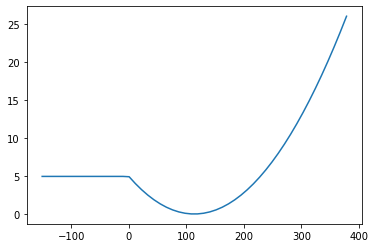

In [19]:
plt.plot(profile["values"], profile["likelihood"] - likemin);

## Plot obtained results for sigma

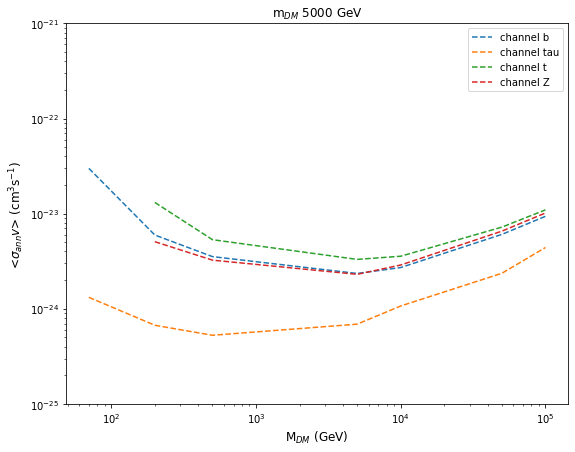

In [20]:
plt.figure(figsize=(9,7))
plt.ylim(1e-25, 1e-21)
plt.ylabel(r"<$\sigma_{ann}v$> (cm$^3$s$^{-1}$)", fontsize=12)
plt.xlabel("M$_{DM}$ (GeV)", fontsize=12)
plt.title('m$_{DM}$ 5000 GeV')

for ch in ["b", "tau"]:
    plt.loglog(
        result[ch]["mass"].data,
        result[ch]["sigma_v"].data,
        ls="--",
        label='channel {}'.format(ch)
       )
#plot only not None values for sigma
for ch in ["t","Z"]:
    masses = result[ch]["mass"].data[1:]
    sigmas = result[ch]["sigma_v"].data[1:]
    plt.loglog(
        masses,
        sigmas,
        ls="--",
        label='channel {}'.format(ch)
       )
plt.legend();